# Packages & Setup

In [0]:
#import packages, must have!
import os
import json
import os.path
import pandas as pd
import numpy as np
import pickle
import time

# visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud,STOPWORDS

# data cleaning
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.stem import *
import re
import string

# model preparation
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# build an NN model
import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM,GRU, Dropout, Input, Bidirectional
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, GlobalMaxPool1D, concatenate
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Lambda
from keras import backend as K


# SVM and LASSO
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso 
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

## ELMo and ULMFit packages are downloaded in the models section.


In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Base directory 
base_dir = '/content/drive/My Drive/PeerRead-master/data'


#acl data
acl_data_dir = os.path.join(base_dir, 'acl_2017')
acl_reviews_dir = os.path.join(acl_data_dir, 'reviews_all')
acl_parsed_dir = os.path.join(acl_data_dir, 'parsed_all')
acl_accepted = os.path.join(base_dir, 'acl_accepted.txt')

#iclr data
iclr_data_dir = os.path.join(base_dir, 'iclr_2017')
iclr_reviews_dir = os.path.join(iclr_data_dir, 'reviews_all') 
iclr_parsed_dir = os.path.join(iclr_data_dir, 'parsed_all') 

#conll data
conll_data_dir = os.path.join(base_dir, 'conll_2016')
conll_reviews_dir = os.path.join(conll_data_dir, 'reviews_all') 
conll_parsed_dir = os.path.join(conll_data_dir, 'parsed_all') 

#arxiv data - buna birlikte bakalim
arxiv_data_dir = os.path.join(base_dir, 'arxiv.2007-2017')
arxiv_reviews_dir = os.path.join(arxiv_data_dir, 'reviews_all') 
arxiv_parsed_dir = os.path.join(arxiv_data_dir, 'parsed_all') 


# nips (keske...) bu klasörün alti bos :)
nips_real_dir = os.path.join(base_dir, 'nips_2013-2017')
nips_2016 = os.path.join(nips_real_dir, '2016')
nips_2016_review = os.path.join(nips_2016, 'Reviews')

nips_2015 = os.path.join(nips_real_dir, '2015')
nips_2015_review = os.path.join(nips_2015, 'reviews_all')

nips_2014 = os.path.join(nips_real_dir, '2014')
nips_2014_review = os.path.join(nips_2014, 'reviews_all')


# Data Import

### ACL Import

In [0]:
#train+dev reviews
path_to_json = acl_reviews_dir
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files) 

for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
print(json_text)

# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data_acl_train_reviews = pd.DataFrame(columns=['reviews','abstract','comments','comments2','comments3', 'histories', 'title','idnumber'])

# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
     
        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        reviews = json_text['reviews']
        abstract = json_text['abstract']
        comments = json_text['reviews'][0]['comments']
        comments2 =json_text['reviews'][1]['comments'] if len(json_text['reviews']) is not 1 else " "
        comments3 =json_text['reviews'][2]['comments'] if len(json_text['reviews']) > 2 else " " #max 3 reviews for acl data
        histories = json_text['histories']
        title = json_text['title']
        idnumber = json_text['id']
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data_acl_train_reviews.loc[index] = [reviews, abstract, comments, comments2,comments3, histories, title, idnumber]

# now that we have the pertinent json data in our DataFrame let's look at it
print(jsons_data_acl_train_reviews)

['741.json', '726.json', '723.json', '729.json', '727.json', '715.json', '691.json', '684.json', '706.json', '699.json', '676.json', '654.json', '660.json', '606.json', '614.json', '649.json', '636.json', '657.json', '627.json', '619.json', '588.json', '561.json', '563.json', '564.json', '562.json', '578.json', '579.json', '557.json', '554.json', '553.json', '543.json', '520.json', '501.json', '483.json', '489.json', '503.json', '494.json', '484.json', '516.json', '524.json', '481.json', '395.json', '477.json', '462.json', '467.json', '447.json', '440.json', '444.json', '388.json', '433.json', '419.json', '387.json', '384.json', '350.json', '369.json', '371.json', '382.json', '375.json', '376.json', '343.json', '338.json', '352.json', '367.json', '365.json', '335.json', '333.json', '251.json', '276.json', '288.json', '318.json', '326.json', '331.json', '239.json', '270.json', '266.json', '256.json', '226.json', '237.json', '201.json', '220.json', '193.json', '214.json', '222.json', '18

In [0]:
#train+dev parsed
path_to_json = acl_parsed_dir
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files)  
# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data_acl_train_parsed = pd.DataFrame(columns=['name', 'title1', 'authors', 'text','heading'])

# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js),encoding='utf-8') as json_file:
        json_text = json.load(json_file)
     
        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        name = json_text['name']
        title1 = json_text['metadata']['title']
        authors = json_text['metadata']['authors']
        text = json_text['metadata']['sections'][0]['text']
        heading = json_text['metadata']['sections'][0]['heading']
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data_acl_train_parsed.loc[index] = [name, title1, authors, text, heading]

# now that we have the pertinent json data in our DataFrame let's look at it
print(jsons_data_acl_train_parsed)

['86.pdf.json', '108.pdf.json', '117.pdf.json', '94.pdf.json', '105.pdf.json', '104.pdf.json', '87.pdf.json', '96.pdf.json', '107.pdf.json', '97.pdf.json', '122.pdf.json', '128.pdf.json', '130.pdf.json', '134.pdf.json', '145.pdf.json', '150.pdf.json', '214.pdf.json', '216.pdf.json', '169.pdf.json', '178.pdf.json', '173.pdf.json', '193.pdf.json', '182.pdf.json', '180.pdf.json', '201.pdf.json', '220.pdf.json', '222.pdf.json', '226.pdf.json', '237.pdf.json', '239.pdf.json', '326.pdf.json', '256.pdf.json', '251.pdf.json', '331.pdf.json', '333.pdf.json', '335.pdf.json', '318.pdf.json', '270.pdf.json', '288.pdf.json', '276.pdf.json', '266.pdf.json', '338.pdf.json', '343.pdf.json', '350.pdf.json', '352.pdf.json', '384.pdf.json', '387.pdf.json', '367.pdf.json', '365.pdf.json', '388.pdf.json', '371.pdf.json', '376.pdf.json', '375.pdf.json', '382.pdf.json', '369.pdf.json', '395.pdf.json', '419.pdf.json', '433.pdf.json', '440.pdf.json', '444.pdf.json', '447.pdf.json', '494.pdf.json', '501.pdf.jso

In [0]:
#extracting id number from parsed data
jsons_data_acl_train_parsed['idnumber'] = jsons_data_acl_train_parsed['name'][:]
jsons_data_acl_train_parsed['idnumber'] = jsons_data_acl_train_parsed['idnumber'].astype(str)
jsons_data_acl_train_parsed['idnumber'] = jsons_data_acl_train_parsed['idnumber'].str.replace('.pdf','')
jsons_data_acl_train_parsed['idnumber'] = jsons_data_acl_train_parsed['idnumber'].str.strip()
jsons_data_acl_train_parsed.head(10)

,name,title1,authors,text,heading,idnumber
0,86.pdf,A Syntactic Neural Model for General-Purpose C...,[],1 000\n011\n012\n013\n014\n015\n016\n017\n018\...,None,86
1,108.pdf,A Multigraph-based Model for Overlapping Entit...,[],1 000\n011\n012\n013\n014\n015\n016\n017\n018\...,None,108
2,117.pdf,Improved Neural Relation Detection for Knowled...,[],1 000\n011\n012\n013\n014\n015\n016\n017\n018\...,None,117
3,94.pdf,A Full Non-Monotonic Transition System for Unr...,[],1 000\n011\n012\n013\n014\n015\n016\n017\n018\...,None,94
4,105.pdf,Morphological Inflection Generation with Hard ...,[],1 000\n011\n012\n013\n014\n015\n016\n017\n018\...,None,105
5,104.pdf,None,[],1 000\n011\n012\n013\n014\n015\n016\n017\n018\...,None,104
6,87.pdf,PositionRank: An Unsupervised Approach to Keyp...,[],1 000\n011\n012\n013\n014\n015\n016\n017\n018\...,None,87
7,96.pdf,Sarcasm SIGN: Interpreting Sarcasm with Sentim...,[],1 000\n011\n012\n013\n014\n015\n016\n017\n018\...,None,96
8,107.pdf,Weakly Supervised Cross-Lingual Named Entity R...,[],1 000\n010\n011\n012\n013\n014\n015\n016\n017\...,None,107
9,97.pdf,None,[],1 000\n011\n012\n013\n014\n015\n016\n017\n018\...,None,97


In [0]:
jsons_data_acl_train_reviews['idnumber'] = jsons_data_acl_train_reviews['idnumber'].astype(str).str.strip()
jsons_data_acl_train_reviews.head(10)

,reviews,abstract,comments,comments2,comments3,histories,title,idnumber
0,"[{'IMPACT': '4', 'SUBSTANCE': '4', 'APPROPRIAT...",This paper presents a new graph-based approach...,This paper presents a graph-based approach for...,- Strengths:\n\nThe paper proposes a new metho...,,[],Automatic Induction of Synsets from a Graph of...,741
1,"[{'IMPACT': '4', 'SUBSTANCE': '4', 'APPROPRIAT...",We present an approach to rapidly and easily b...,The paper presents a neural model for predicti...,This paper proposes a simple attention-based R...,This paper proposes an approach to learning a ...,[],Learning a Neural Semantic Parser from User Fe...,726
2,"[{'IMPACT': '4', 'SUBSTANCE': '4', 'APPROPRIAT...",We present in this paper a novel framework for...,This is a nice paper on morphological segmenta...,This paper continues the line of work for appl...,- Strengths:\n I find the idea of using morpho...,[],MORSE: Semantic-ally Drive-n MORpheme SEgment-er,723
3,"[{'IMPACT': '4', 'SUBSTANCE': '4', 'APPROPRIAT...",How fake news goes viral via social media? How...,- Strengths:\n\nThe authors propose a kernel-b...,,,[],Detect Rumors in Microblog Posts Using Propaga...,729
4,"[{'IMPACT': '4', 'SUBSTANCE': '4', 'APPROPRIAT...",Framing is a political strategy in which polit...,"- Strengths: 1) an interesting task, 2) the pa...",- Strengths: The authors address a very challe...,,[],Leveraging Behavioral and Social Information f...,727
5,"[{'IMPACT': '5', 'SUBSTANCE': '3', 'APPROPRIAT...",This paper proposes to tackle open-domain ques...,"- Strengths:\n*- Task\n*- Simple model, yet th...",- Strengths:\n\nThe authors focus on a very ch...,,[],Reading Wikipedia to Answer Open-Domain Questions,715
6,"[{'IMPACT': '5', 'SUBSTANCE': '4', 'APPROPRIAT...",Type-level word embeddings use the same set of...,- Overview:\n\nThe paper proposes a new model ...,,,[],Ontology-Aware Token Embeddings for Prepositio...,691
7,"[{'IMPACT': '4', 'SUBSTANCE': '4', 'APPROPRIAT...",In this paper we study the problem of answerin...,This paper presents a gated attention mechanis...,This paper presents an interesting model for r...,- Strengths:\n\n* Paper is very well-written a...,[],Gated-Attention Readers for Text Comprehension,684
8,"[{'IMPACT': '5', 'SUBSTANCE': '4', 'APPROPRIAT...",Our goal is to create a convenient natural lan...,Thanks for the response. I look forward to rea...,- Strengths: This paper reports on an interest...,- Strengths:\n\nThe ideas and the task address...,[],Naturalizing a Programming Language via Intera...,706
9,"[{'IMPACT': '5', 'SUBSTANCE': '4', 'APPROPRIAT...",Keyphrase provides highly-summative informatio...,This paper proposes to use an encoder-decoder ...,This paper divides the keyphrases into two typ...,- Strengths:\n\nNovel model. I particularly l...,[],Deep Keyphrase Generation,699


In [0]:
acl_data = pd.merge(jsons_data_acl_train_reviews, jsons_data_acl_train_parsed, left_on='idnumber',right_on='idnumber', how='inner', sort=True)
print(acl_data.head(10))

                                             reviews  ... heading
0  [{'IMPACT': '3', 'SUBSTANCE': '4', 'APPROPRIAT...  ...    None
1  [{'IMPACT': '3', 'SUBSTANCE': '4', 'APPROPRIAT...  ...    None
2  [{'IMPACT': '3', 'SUBSTANCE': '4', 'APPROPRIAT...  ...    None
3  [{'IMPACT': '3', 'SUBSTANCE': '3', 'APPROPRIAT...  ...    None
4  [{'IMPACT': '3', 'SUBSTANCE': '5', 'APPROPRIAT...  ...    None
5  [{'SUBSTANCE': '4', 'APPROPRIATENESS': '5', 'P...  ...    None
6  [{'IMPACT': '3', 'SUBSTANCE': '4', 'APPROPRIAT...  ...    None
7  [{'IMPACT': '3', 'SUBSTANCE': '4', 'APPROPRIAT...  ...    None
8  [{'IMPACT': '4', 'SUBSTANCE': '3', 'APPROPRIAT...  ...    None
9  [{'IMPACT': '2', 'SUBSTANCE': '3', 'APPROPRIAT...  ...    None

[10 rows x 13 columns]


In [0]:
acl_accepted = pd.read_csv('/content/drive/My Drive/PeerRead-master/data/acl_accepted.txt', sep='__'  , engine='python', header = None)

In [0]:
acl_accepted = acl_accepted.rename(columns = {0:"accepted_title"}) 
acl_accepted.head(5)

,accepted_title
0,Token and Type Constraints for Cross-Lingual P...
1,Finding Optimal 1-Endpoint-Crossing Trees
2,Grounding Action Descriptions in Videos
3,Branch and Bound Algorithm for Dependency Pars...
4,Weakly Supervised Learning of Semantic Parsers...


In [0]:
acl_data_new = pd.merge(acl_data, acl_accepted, left_on='title',right_on='accepted_title', how='left', sort=True)
print(acl_data_new.head(2))
acl_data_new.shape

                                             reviews  ...                                     accepted_title
0  [{'IMPACT': '3', 'SUBSTANCE': '4', 'APPROPRIAT...  ...                                                NaN
1  [{'IMPACT': '3', 'SUBSTANCE': '3', 'APPROPRIAT...  ...  A Corpus of Annotated Revisions for Studying A...

[2 rows x 14 columns]


(137, 14)

In [0]:
import numpy as np
acl_data_new = acl_data_new.replace(np.nan, 'None', regex=True)

In [0]:
acl_data_new.loc[acl_data_new['accepted_title'] != "None" , 'accepted'] = "True"
acl_data_new.loc[acl_data_new['accepted_title'] == "None" , 'accepted'] = "False"

### ICLR Import

In [0]:
#train+dev+test reviews
path_to_json = iclr_reviews_dir
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files)  

for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
print(json_text)

# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data_iclr_train_reviews = pd.DataFrame(columns=['reviews','abstract','comments', 'comments2',
                                                      'comments3','comments4','comments5','comments6',
                                                      'comments7','comments8','comments9','comments10',
                                                      'comments11','comments12','comments13','comments14','comments15',
                                                      'comments16', 'comments17','comments18', 'comments19','comments20',
                                                      'histories', 'title','idnumber', 'accepted'])

# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
     
        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        reviews = json_text['reviews']
        abstract = json_text['abstract']
        comments = json_text['reviews'][0]['comments']
        comments2 =json_text['reviews'][1]['comments'] if len(json_text['reviews']) is not 1 else " "
        comments3 =json_text['reviews'][2]['comments'] if len(json_text['reviews']) > 2 else " "
        comments4 =json_text['reviews'][3]['comments'] if len(json_text['reviews']) > 3 else " "
        comments5 =json_text['reviews'][4]['comments'] if len(json_text['reviews']) > 4 else " "
        comments6 =json_text['reviews'][5]['comments'] if len(json_text['reviews']) > 5 else " "
        comments7 =json_text['reviews'][6]['comments'] if len(json_text['reviews']) > 6 else " "
        comments8 =json_text['reviews'][7]['comments'] if len(json_text['reviews']) > 7 else " "
        comments9 =json_text['reviews'][8]['comments'] if len(json_text['reviews']) > 8 else " "
        comments10 =json_text['reviews'][9]['comments'] if len(json_text['reviews']) > 9 else " "
        comments11 =json_text['reviews'][10]['comments'] if len(json_text['reviews']) > 10 else " "
        comments12 =json_text['reviews'][11]['comments'] if len(json_text['reviews']) > 11 else " "
        comments13 =json_text['reviews'][12]['comments'] if len(json_text['reviews']) > 12 else " "
        comments14 =json_text['reviews'][13]['comments'] if len(json_text['reviews']) > 13 else " "
        comments15 =json_text['reviews'][14]['comments'] if len(json_text['reviews']) > 14 else " "
        comments16 =json_text['reviews'][15]['comments'] if len(json_text['reviews']) > 15 else " "
        comments17 =json_text['reviews'][16]['comments'] if len(json_text['reviews']) > 16 else " "
        comments18 =json_text['reviews'][17]['comments'] if len(json_text['reviews']) > 17 else " "
        comments19 =json_text['reviews'][18]['comments'] if len(json_text['reviews']) > 18 else " "
        comments20 =json_text['reviews'][19]['comments'] if len(json_text['reviews']) > 19 else " "   
        histories = json_text['histories']
        title = json_text['title']
        idnumber = json_text['id']
        accepted = json_text['accepted']
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data_iclr_train_reviews.loc[index] = [reviews, abstract, comments, comments2,comments3,comments4, 
                                                    comments5,comments6,comments7,comments8,comments9, comments10,
                                                    comments11, comments12, comments13, comments14, comments15,
                                                    comments16, comments17, comments18, comments19,comments20,
                                                    histories, title, idnumber, accepted]

# now that we have the pertinent json data in our DataFrame let's look at it
print(jsons_data_iclr_train_reviews)

['320.json', '322.json', '324.json', '321.json', '325.json', '332.json', '330.json', '329.json', '331.json', '328.json', '333.json', '336.json', '334.json', '335.json', '339.json', '338.json', '342.json', '343.json', '340.json', '341.json', '344.json', '349.json', '350.json', '345.json', '348.json', '353.json', '356.json', '354.json', '355.json', '351.json', '357.json', '358.json', '361.json', '362.json', '360.json', '367.json', '363.json', '366.json', '368.json', '365.json', '370.json', '374.json', '369.json', '371.json', '373.json', '372.json', '377.json', '376.json', '378.json', '375.json', '379.json', '381.json', '384.json', '380.json', '383.json', '391.json', '389.json', '390.json', '388.json', '387.json', '392.json', '401.json', '397.json', '393.json', '400.json', '396.json', '394.json', '399.json', '398.json', '395.json', '402.json', '404.json', '403.json', '406.json', '405.json', '411.json', '408.json', '409.json', '407.json', '410.json', '412.json', '418.json', '413.json', '41

In [0]:
#train+dev+test parsed
path_to_json = iclr_parsed_dir
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files) 
# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data_iclr_train_parsed = pd.DataFrame(columns=['name', 'title1', 'authors', 'text','heading'])

# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js),encoding='utf-8') as json_file:
        json_text = json.load(json_file)
     
        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        name = json_text['name']
        title1 = json_text['metadata']['title']
        authors = json_text['metadata']['authors']
        text = json_text['metadata']['sections'][0]['text'] if json_text['metadata']['sections'] is not None else " "
        heading = json_text['metadata']['sections'][0]['heading'] if json_text['metadata']['sections'] is not None else " "
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data_iclr_train_parsed.loc[index] = [name, title1, authors, text, heading]

# now that we have the pertinent json data in our DataFrame let's look at it
print(jsons_data_iclr_train_parsed)

['320.pdf.json', '318.pdf.json', '324.pdf.json', '321.pdf.json', '319.pdf.json', '325.pdf.json', '322.pdf.json', '329.pdf.json', '330.pdf.json', '328.pdf.json', '331.pdf.json', '333.pdf.json', '332.pdf.json', '338.pdf.json', '339.pdf.json', '340.pdf.json', '335.pdf.json', '336.pdf.json', '334.pdf.json', '341.pdf.json', '342.pdf.json', '344.pdf.json', '343.pdf.json', '348.pdf.json', '350.pdf.json', '345.pdf.json', '349.pdf.json', '353.pdf.json', '351.pdf.json', '354.pdf.json', '355.pdf.json', '357.pdf.json', '356.pdf.json', '365.pdf.json', '362.pdf.json', '358.pdf.json', '363.pdf.json', '360.pdf.json', '361.pdf.json', '366.pdf.json', '367.pdf.json', '369.pdf.json', '368.pdf.json', '372.pdf.json', '375.pdf.json', '374.pdf.json', '373.pdf.json', '370.pdf.json', '371.pdf.json', '376.pdf.json', '377.pdf.json', '379.pdf.json', '378.pdf.json', '381.pdf.json', '383.pdf.json', '387.pdf.json', '384.pdf.json', '388.pdf.json', '380.pdf.json', '389.pdf.json', '390.pdf.json', '391.pdf.json', '392.pd

In [0]:
#extracting id number from parsed data
jsons_data_iclr_train_parsed['idnumber'] = jsons_data_iclr_train_parsed['name'][:]
jsons_data_iclr_train_parsed['idnumber'] = jsons_data_iclr_train_parsed['idnumber'].astype(str)
jsons_data_iclr_train_parsed['idnumber'] = jsons_data_iclr_train_parsed['idnumber'].str.replace('.pdf','')
jsons_data_iclr_train_parsed['idnumber'] = jsons_data_iclr_train_parsed['idnumber'].str.strip()
jsons_data_iclr_train_parsed.head(5)

,name,title1,authors,text,heading,idnumber
0,320.pdf,None,"[FITTED Q-ITERATION, Alex X. Lee, Sergey Levin...",Visual servoing is a classic problem in roboti...,1 INTRODUCTION,320
1,318.pdf,LEARNING GRAPHICAL STATE TRANSITIONS,[Daniel D. Johnson],Many different types of data can be formulated...,1 INTRODUCTION,318
2,324.pdf,None,"[EFFICIENT CONVNETS, Hao Li, Asim Kadav, Igor ...",The ImageNet challenge has led to significant ...,1 INTRODUCTION,324
3,321.pdf,STOCHASTIC NEURAL NETWORKS FOR HIERARCHICAL RE...,"[Carlos Florensa, Yan Duan, Pieter Abbeel]",Deep reinforcement learning has achieved many ...,None,321
4,319.pdf,None,"[ATTENTION TRANSFER, Sergey Zagoruyko, Nikos K...","As humans, we need to pay attention in order t...",1 INTRODUCTION,319


In [0]:
jsons_data_iclr_train_reviews['idnumber'] = jsons_data_iclr_train_reviews['idnumber'].astype(str).str.strip()
jsons_data_iclr_train_reviews.head(10)

,reviews,abstract,comments,comments2,comments3,comments4,comments5,comments6,comments7,comments8,comments9,comments10,comments11,comments12,comments13,comments14,comments15,comments16,comments17,comments18,comments19,comments20,histories,title,idnumber,accepted
0,"[{'DATE': '06 Feb 2017', 'TITLE': 'ICLR commit...",Visual servoing involves choosing actions that...,"All reviewers viewed the paper favourably, alt...",The paper proposes a novel approach for learni...,This paper investigates the benefits of visual...,1) Summary\n\nThis paper proposes to tackle vi...,,,,"All reviewers viewed the paper favourably, alt...",The paper proposes a novel approach for learni...,This paper investigates the benefits of visual...,1) Summary\n\nThis paper proposes to tackle vi...,,,,,,,,,,[],Learning Visual Servoing with Deep Features an...,320,True
1,"[{'DATE': '06 Feb 2017', 'TITLE': 'ICLR commit...",Automatically determining the optimal size of ...,The paper presents a clean framework for optim...,I just added a new version of the paper with e...,"Dear all,\n\nBelow are some more responses to ...","Dear Reviewer 2,\n\nThank you again for your r...",This paper proposes a nonparametric neural net...,I agree with reviewer 2 on the interesting par...,This paper addresses the problem of allowing n...,"Dear Reviewers,\n\nIn response to the first qu...",,The paper presents a clean framework for optim...,I just added a new version of the paper with e...,"Dear all,\n\nBelow are some more responses to ...","Dear Reviewer 2,\n\nThank you again for your r...",This paper proposes a nonparametric neural net...,I agree with reviewer 2 on the interesting par...,This paper addresses the problem of allowing n...,"Dear Reviewers,\n\nIn response to the first qu...",,,,[],Nonparametric Neural Networks,322,True
2,"[{'DATE': '06 Feb 2017', 'TITLE': 'ICLR commit...",The success of CNNs in various applications is...,The paper presents a simple but effective appr...,Just some feedback on your idea:\n\nThe criter...,We would like to thank all reviewers for their...,"The idea of ""pruning where it matters"" is grea...",This paper prunes entire groups of filters in ...,This paper proposes a simple method for prunin...,This paper proposes a very simple idea (prune ...,The paper presents a simple but effective appr...,Just some feedback on your idea:\n\nThe criter...,We would like to thank all reviewers for their...,"The idea of ""pruning where it matters"" is grea...",This paper prunes entire groups of filters in ...,This paper proposes a simple method for prunin...,This paper proposes a very simple idea (prune ...,,,,,,,[],Pruning Filters for Efficient ConvNets,324,True
3,"[{'IS_META_REVIEW': True, 'comments': 'I like ...",Deep reinforcement learning has achieved many ...,I like the setting presented in this paper but...,The authors provide an approach to policy lear...,Here we summarize the updates performed on the...,"Interesting work on hierarchical control, simi...",*Edited the score 6->7.\n\nThe paper presents ...,I like the setting presented in this paper but...,Sorry for some last minute questions. What is ...,"In figure 1, is it correct that (1) concatenat...",,,I like the setting presented in this paper but...,The authors provide an approach to policy lear...,Here we summarize the updates performed on the...,"Interesting work on hierarchical control, simi...",*Edited the score 6->7.\n\nThe paper presents ...,I like the setting presented in this paper but...,Sorry for some last minute questions. What is ...,"In figure 1, is it correct that (1) concatenat...",,,[],Stochastic Neural Networks for Hierarchical Re...,321,True
4,"[{'IS_META_REVIEW': True, 'comments': 'Summary...","In this work, we investigate a novel training ...",Summary:\nThis paper introduces a heuristic ap...,"Infusion training is a new, somewhat heuristic...","We updated the paper, the main changes are:\n\...",This paper trains a generative model which tra...,,The paper presents a method for trai

In [0]:
iclr_data = pd.merge(jsons_data_iclr_train_reviews, jsons_data_iclr_train_parsed, left_on='idnumber',right_on='idnumber', how='inner', sort=True)
print(iclr_data.head(10))

                                             reviews  ...         heading
0  [{'IS_META_REVIEW': True, 'comments': 'This pa...  ...  1 INTRODUCTION
1  [{'IS_META_REVIEW': True, 'comments': 'This ni...  ...  1 INTRODUCTION
2  [{'IS_META_REVIEW': True, 'comments': 'In ligh...  ...  1 INTRODUCTION
3  [{'DATE': '06 Feb 2017', 'TITLE': 'ICLR commit...  ...  1 INTRODUCTION
4  [{'IS_META_REVIEW': True, 'comments': 'This pa...  ...  1 INTRODUCTION
5  [{'IS_META_REVIEW': True, 'comments': 'This wo...  ...            None
6  [{'DATE': '08 Feb 2017', 'TITLE': 'interesting...  ...  1 INTRODUCTION
7  [{'IS_META_REVIEW': True, 'comments': 'This pa...  ...  1 INTRODUCTION
8  [{'IS_META_REVIEW': True, 'comments': 'The pap...  ...  1 INTRODUCTION
9  [{'IS_META_REVIEW': True, 'comments': 'I think...  ...            None

[10 rows x 31 columns]


### CONLL Import

In [0]:
#train+dev+test reviews
path_to_json = conll_reviews_dir
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files) 

for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
print(json_text)

# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data_conll_train_reviews = pd.DataFrame(columns=['reviews','abstract','comments','comments2','comments3', 'title','idnumber'])

# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
     
        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        reviews = json_text['reviews']
        abstract = json_text['abstract']
        comments = json_text['reviews'][0]['comments']
        comments2 =json_text['reviews'][1]['comments'] if len(json_text['reviews']) is not 1 else " "
        comments3 =json_text['reviews'][2]['comments'] if len(json_text['reviews']) > 2 else " "
        title = json_text['title']
        idnumber = json_text['id']
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data_conll_train_reviews.loc[index] = [reviews, abstract, comments,comments2, comments3, title, idnumber]

# now that we have the pertinent json data in our DataFrame let's look at it
print(jsons_data_conll_train_reviews)

['143.json', '176.json', '166.json', '163.json', '151.json', '7.json', '165.json', '11.json', '13.json', '12.json', '18.json', '66.json', '86.json', '91.json', '124.json', '98.json', '25.json', '103.json', '132.json', '129.json', '137.json', '142.json']
{'title': 'Exploring Prediction Uncertainty in Machine Translation Quality Estimation', 'abstract': 'Machine Translation Quality Estimation is a notoriously difficult task, which lessens its usefulness in real-world translation environments. Such scenarios can be improved if quality predictions are accompanied by a measure of uncertainty. However, models in this task are traditionally evaluated only in terms of point estimate metrics, which do not take prediction uncertainty into account. We investigate probabilistic methods for Quality Estimation that can provide well-calibrated uncertainty estimates and evaluate them in terms of their full posterior predictive distributions. We also show how this posterior information can be useful in

In [0]:
#train+dev+test parsed
path_to_json = conll_parsed_dir
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files) 
# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data_conll_train_parsed = pd.DataFrame(columns=['name', 'title1', 'authors', 'text','heading'])

# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js),encoding='utf-8') as json_file:
        json_text = json.load(json_file)
     
        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        name = json_text['name']
        title1 = json_text['metadata']['title']
        authors = json_text['metadata']['authors']
        text = json_text['metadata']['sections'][1]['text'] if json_text['metadata']['sections'] is not None else "None"
        heading = json_text['metadata']['sections'][1]['heading'] if json_text['metadata']['sections'] is not None else "None"
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data_conll_train_parsed.loc[index] = [name, title1, authors, text, heading]

# now that we have the pertinent json data in our DataFrame let's look at it
print(jsons_data_conll_train_parsed)

['91.pdf.json', '98.pdf.json', '103.pdf.json', '137.pdf.json', '151.pdf.json', '143.pdf.json', '132.pdf.json', '129.pdf.json', '124.pdf.json', '142.pdf.json', '163.pdf.json', '176.pdf.json', '165.pdf.json', '166.pdf.json', '18.pdf.json', '11.pdf.json', '25.pdf.json', '13.pdf.json', '12.pdf.json', '7.pdf.json', '66.pdf.json', '86.pdf.json']
       name  ...                        heading
0    91.pdf  ...                 1 Introduction
1    98.pdf  ...                 1 Introduction
2   103.pdf  ...                 1 Introduction
3   137.pdf  ...                 1 Introduction
4   151.pdf  ...                 1 Introduction
5   143.pdf  ...                 1 Introduction
6   132.pdf  ...                 1 Introduction
7   129.pdf  ...                 1 Introduction
8   124.pdf  ...                 1 Introduction
9   142.pdf  ...                 1 Introduction
10  163.pdf  ...                 1 Introduction
11  176.pdf  ...                 1 Introduction
12  165.pdf  ...  1 Introduction &

In [0]:
#extracting id number from parsed data
jsons_data_conll_train_parsed['idnumber'] = jsons_data_conll_train_parsed['name'][:]
jsons_data_conll_train_parsed['idnumber'] = jsons_data_conll_train_parsed['idnumber'].astype(str)
jsons_data_conll_train_parsed['idnumber'] = jsons_data_conll_train_parsed['idnumber'].str.replace('.pdf','')
jsons_data_conll_train_parsed['idnumber'] = jsons_data_conll_train_parsed['idnumber'].str.strip()
jsons_data_conll_train_parsed.head(5)

,name,title1,authors,text,heading,idnumber
0,91.pdf,Compression of Neural Machine Translation Mode...,[],Neural Machine Translation (NMT) is a simple n...,1 Introduction,91
1,98.pdf,None,[],"In the last two decades, many dependency treeb...",1 Introduction,98
2,103.pdf,Measuring Topic Quality using Word Buckets,[],Starting with the formalization of the notion ...,1 Introduction,103
3,137.pdf,When a Red Herring is Not a Red Herring: Using...,[],"In recent years, distributional representation...",1 Introduction,137
4,151.pdf,Parsing for Universal Dependencies without tra...,[],Grammar induction and unsupervised dependency ...,1 Introduction,151


In [0]:
jsons_data_conll_train_reviews['idnumber'] = jsons_data_conll_train_reviews['idnumber'].astype(str).str.strip()
jsons_data_conll_train_reviews.head(10)
print(jsons_data_conll_train_reviews.shape)

(22, 7)


In [0]:
conll_data = pd.merge(jsons_data_conll_train_reviews, jsons_data_conll_train_parsed, left_on='idnumber',right_on='idnumber', how='inner', sort=True)
print(conll_data.head(10))

                                             reviews  ...         heading
0  [{'comments': 'This paper proposes a method fo...  ...  1 Introduction
1  [{'comments': 'The authors present a new versi...  ...  1 Introduction
2  [{'comments': 'I reviewed this paper earlier, ...  ...  1 Introduction
3  [{'comments': 'This paper proposed a very inte...  ...  1 Introduction
4  [{'comments': 'The paper describes an MT train...  ...  1 Introduction
5  [{'comments': 'This paper models event linking...  ...  1 Introduction
6  [{'comments': 'A combination of word2vec and L...  ...  1 Introduction
7  [{'comments': 'General comments
==============...  ...  1 Introduction
8  [{'comments': 'The paper explores the use of p...  ...  1 Introduction
9  [{'comments': 'This paper describes four metho...  ...  1 Introduction

[10 rows x 12 columns]


In [0]:
conll_data['histories'] = " "

In [0]:
conll_accepted = drive.CreateFile({'id': '1oXjYl5hemw-DOC8UasdE_UmmqKJldt7k'})
conll_accepted.GetContentFile('conll_accepted_papers.csv')

In [0]:
conll_accepted = pd.read_csv('conll_accepted_papers.csv', sep=';', engine='python', encoding = 'latin-1')

In [0]:
conll_data_new = pd.merge(conll_data, conll_accepted, left_on='title',right_on='Title', how='left', sort=True)
print(conll_data_new.head(22))
conll_data_new.shape

                                              reviews  ...                                              Title
0   [{'comments': 'No details are provided on the ...  ...                                                NaN
1   [{'comments': 'This paper presents a transitio...  ...                                                NaN
2   [{'comments': 'This paper investigates three s...  ...  Compression of Neural Machine Translation Mode...
3   [{'comments': 'The authors present a new versi...  ...  Coreference in Wikipedia: Main Concept Resolution
4   [{'comments': 'This paper proposes an approach...  ...  Cross-Lingual Named Entity Recognition via Wik...
5   [{'comments': 'This paper presents results on ...  ...                                                NaN
6   [{'comments': 'This paper proposes a method fo...  ...                                                NaN
7   [{'comments': 'This paper models event linking...  ...  Event Linking with Sentential Features from Co...
8   [{'com

(22, 14)

In [0]:
conll_data_new = conll_data_new.rename(columns = {"Title":"accepted_title"}) 

In [0]:
import numpy as np
df1 = conll_data_new.replace(np.nan, 'None', regex=True)

In [0]:
conll_data_new.loc[df1['accepted_title'] != "None" , 'accepted'] = "True"
conll_data_new.loc[df1['accepted_title'] == "None" , 'accepted'] = "False"

### ARXIV Import

In [0]:
#train+dev reviews
path_to_json = arxiv_reviews_dir
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files) 

# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data_arxiv_train_reviews = pd.DataFrame(columns=['accepted', 'abstract','title', 'idnumber'])


# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
     
        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        accepted = json_text['accepted']
        abstract = json_text['abstract']
        title = json_text['title']
        idnumber = json_text['id']
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data_arxiv_train_reviews.loc[index] = [accepted, abstract, title, idnumber]

# now that we have the pertinent json data in our DataFrame let's look at it
print(jsons_data_arxiv_train_reviews.head(5))

['1705.05229.json', '1705.05414.json', '1705.05366.json', '1705.05249.json', '1705.05311.json', '1705.05363.json', '1705.05263.json', '1705.05316.json', '1705.05267.json', '1705.05326.json', '1705.05427.json', '1705.05437.json', '1705.05515.json', '1705.05742.json', '1705.05551.json', '1705.05584.json', '1705.05720.json', '1705.05665.json', '1705.05633.json', '1705.05735.json', '1705.05637.json', '1705.05690.json', '1705.05756.json', '1705.05765.json', '1705.05769.json', '1705.06106.json', '1705.06000.json', '1705.06058.json', '1705.05952.json', '1705.05823.json', '1705.05992.json', '1705.05940.json', '1705.05983.json', '1705.05933.json', '1705.06224.json', '1705.06338.json', '1705.06342.json', '1705.06353.json', '1705.06573.json', '1705.06369.json', '1705.06366.json', '1705.06476.json', '1705.06463.json', '1705.06460.json', '1705.06564.json', '1705.06457.json', '1705.06390.json', '1705.06640.json', '1705.06694.json', '1705.06709.json', '1705.07077.json', '1705.06908.json', '1705.06840

In [0]:
import pickle #for saving time
filehandler = open('arxiv1.pkl',"wb")
pickle.dump(jsons_data_arxiv_train_reviews,filehandler)
filehandler.close()

In [0]:
#arxiv1 = drive.CreateFile({'id': '1mD94Smqf31-OpNsF4DG_HQfCDpcmjHgB'})
#arxiv1.GetContentFile('arxiv1.pkl')

In [0]:
#with open('arxiv1.pkl','rb') as filehandler:
    #arxiv1 = pickle.load(filehandler)

In [0]:
#train+dev parsed
path_to_json = arxiv_parsed_dir
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files)  # for me this prints ['foo.json']
# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data_arxiv_train_parsed = pd.DataFrame(columns=['name', 'authors', 'text'])

# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js),encoding='utf-8') as json_file:
        json_text = json.load(json_file)
     
        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        name = json_text['name']
        authors = json_text['metadata']['authors']
        text = json_text['metadata']['sections'][0]['text'] if json_text['metadata']['sections'] is not None else " "
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data_arxiv_train_parsed.loc[index] = [name, authors, text]

# now that we have the pertinent json data in our DataFrame let's look at it
print(jsons_data_arxiv_train_parsed)

['1705.05229.pdf.json', '1705.05414.pdf.json', '1705.05267.pdf.json', '1705.05263.pdf.json', '1705.05249.pdf.json', '1705.05427.pdf.json', '1705.05363.pdf.json', '1705.05366.pdf.json', '1705.05316.pdf.json', '1705.05326.pdf.json', '1705.05311.pdf.json', '1705.05437.pdf.json', '1705.05515.pdf.json', '1705.05742.pdf.json', '1705.05584.pdf.json', '1705.05551.pdf.json', '1705.05633.pdf.json', '1705.05756.pdf.json', '1705.05637.pdf.json', '1705.05735.pdf.json', '1705.05665.pdf.json', '1705.05690.pdf.json', '1705.05720.pdf.json', '1705.05765.pdf.json', '1705.05769.pdf.json', '1705.06106.pdf.json', '1705.06058.pdf.json', '1705.05933.pdf.json', '1705.05823.pdf.json', '1705.05992.pdf.json', '1705.06000.pdf.json', '1705.05983.pdf.json', '1705.05940.pdf.json', '1705.05952.pdf.json', '1705.06224.pdf.json', '1705.06338.pdf.json', '1705.06353.pdf.json', '1705.06564.pdf.json', '1705.06342.pdf.json', '1705.06366.pdf.json', '1705.06369.pdf.json', '1705.06573.pdf.json', '1705.06390.pdf.json', '1705.0647

In [0]:
#extracting id number from parsed data
jsons_data_arxiv_train_parsed['idnumber'] = jsons_data_arxiv_train_parsed['name'][:]
jsons_data_arxiv_train_parsed['idnumber'] = jsons_data_arxiv_train_parsed['idnumber'].astype(str)
jsons_data_arxiv_train_parsed['idnumber'] = jsons_data_arxiv_train_parsed['idnumber'].str.replace('.pdf','')
jsons_data_arxiv_train_parsed['idnumber'] = jsons_data_arxiv_train_parsed['idnumber'].str.strip()
jsons_data_arxiv_train_parsed.head(5)

,name,authors,text,idnumber
0,1705.05229.pdf,"[Zhou Xing, Eddy Baik, Yan Jiao, Nilesh Kulkar...",While both the data volume and heterogeneity i...,1705.05229
1,1705.05414.pdf,"[Mihail Eric, Christopher D. Manning]",With the success of new speech-based humancomp...,1705.05414
2,1705.05267.pdf,"[Ahmed M. Alaa, Scott Hu, Mihaela van der Schaar]",ar X\niv :1\n70 5.\n05 26\n7v 1\n[ cs\n.L G\n]...,1705.05267
3,1705.05263.pdf,"[Ivo Danihelka, Balaji Lakshminarayanan, Benig...",There has been a substantial recent interest i...,1705.05263
4,1705.05249.pdf,[Cedric Nugteren],I. INTRODUCTION\nEfficient and fast software h...,1705.05249


In [0]:
jsons_data_arxiv_train_reviews['idnumber'] = jsons_data_arxiv_train_reviews['idnumber'].astype(str).str.strip()
jsons_data_arxiv_train_reviews.head(10)

,accepted,abstract,title,idnumber
0,False,While both the data volume and heterogeneity o...,Modeling of the Latent Embedding of Music usin...,1705.05229
1,False,Neural task-oriented dialogue systems often st...,Key-Value Retrieval Networks for Task-Oriented...,1705.05414
2,True,"We consider $(\epsilon,\delta)$-PAC maximum-se...",Maximum Selection and Ranking under Noisy Comp...,1705.05366
3,False,This work demonstrates how to accelerate dense...,CLBlast: A Tuned OpenCL BLAS Library,1705.05249
4,False,Until today there has been no systematic compa...,Comparing Titles vs. Full-text for Multi-Label...,1705.05311
5,True,"In many real-world scenarios, rewards extrinsi...",Curiosity-driven Exploration by Self-supervise...,1705.05363
6,False,We train a generator by maximum likelihood and...,Comparison of Maximum Likelihood and GAN-based...,1705.05263
7,False,Local consistencies stronger than arc consiste...,Exploiting the Pruning Power of Strong Local C...,1705.05316
8,True,Critically ill patients in regular wards are v...,Learning from Clinical Judgments: Semi-Markov-...,1705.05267
9,False,We develop the theory and practice of an appro...,"Constrained Bayesian Networks: Theory, Optimiz...",1705.05326


In [0]:
arxiv_data = pd.merge(jsons_data_arxiv_train_reviews, jsons_data_arxiv_train_parsed, left_on='idnumber',right_on='idnumber', how='inner', sort=True)
print(arxiv_data.shape)

(11778, 7)


In [0]:
import pickle #for saving time
filehandler = open('new_arxiv.pkl',"wb")
pickle.dump(arxiv_data,filehandler)
filehandler.close()

In [0]:
arxiv = drive.CreateFile({'id': '1voWToP-ZYn5neKEbt5yfCuAGJGMrMrM3'})
arxiv.GetContentFile('new_arxiv.pkl')

In [0]:
with open('new_arxiv.pkl','rb') as filehandler:
    arxiv_data = pickle.load(filehandler)

### NIPS 2016

In [0]:
nips_papers = drive.CreateFile({'id': '1wAeNV8zKve9a1OnmAxVjg9ewldRju7Hc'})
nips_papers.GetContentFile('papers.csv')

nips_authors = drive.CreateFile({'id': '1V_c-hxTgsc_ipmyWIyLKW7g9DRovuYsa'})
nips_authors.GetContentFile('authors.csv')

nips_paper_authors = drive.CreateFile({'id': '18IcBsPJ3fZLHLOFdCmRmNAm3iGcNee9t'})
nips_paper_authors.GetContentFile('paper_authors.csv')


nips_papers = pd.read_csv('papers.csv')
nips_authors = pd.read_csv('authors.csv')
nips_paper_authors = pd.read_csv('paper_authors.csv')

In [0]:
# filter 2016
nips_2016_papers = nips_papers[nips_papers['year'] == 2016]

In [0]:
#train+dev+test reviews
path_to_json = nips_2016_review
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files)  # for me this prints ['foo.json']

for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
print(json_text)

# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data_nips_train_2016_reviews = pd.DataFrame(columns=['title','abstract','authors','accepted','comments','comments2','comments3','comments4', 'comments5','idnumber'])

# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
     
        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        title = json_text['title']
        abstract = json_text['abstract']
        authors = json_text['authors']
        accepted = json_text['accepted']
        comments = json_text['reviews'][0]['comments'] if len(json_text['reviews']) > 0 else "None"
        comments2 =json_text['reviews'][1]['comments'] if len(json_text['reviews']) > 1 else " "
        comments3 =json_text['reviews'][2]['comments'] if len(json_text['reviews']) > 2 else " "
        comments4 =json_text['reviews'][3]['comments'] if len(json_text['reviews']) > 3 else " "
        comments5 =json_text['reviews'][4]['comments'] if len(json_text['reviews']) > 4 else " "
        idnumber = json_text['id']
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data_nips_train_2016_reviews.loc[index] = [title,abstract,authors, accepted,comments,comments2,comments3,comments4, comments5,idnumber]

# now that we have the pertinent json data in our DataFrame let's look at it
print(jsons_data_nips_train_2016_reviews)

['reviews.json', 'reviews5.json', 'reviews6.json', 'reviews62.json', 'reviews46.json', 'reviews16.json', 'reviews15.json', 'reviews13.json', 'reviews56.json', 'reviews8.json', 'reviews39.json', 'reviews63.json', 'reviews65.json', 'reviews75.json', 'reviews83.json', 'reviews128.json', 'reviews105.json', 'reviews99.json', 'reviews125.json', 'reviews132.json', 'reviews95.json', 'reviews148.json', 'reviews145.json', 'reviews144.json', 'reviews150.json', 'reviews151.json', 'reviews159.json', 'reviews183.json', 'reviews158.json', 'reviews169.json', 'reviews187.json', 'reviews178.json', 'reviews155.json', 'reviews198.json', 'reviews188.json', 'reviews202.json', 'reviews210.json', 'reviews241.json', 'reviews216.json', 'reviews211.json', 'reviews213.json', 'reviews219.json', 'reviews235.json', 'reviews239.json', 'reviews231.json', 'reviews234.json', 'reviews244.json', 'reviews245.json', 'reviews274.json', 'reviews254.json', 'reviews250.json', 'reviews253.json', 'reviews248.json', 'reviews258.js

In [0]:
jsons_data_nips_train_2016_reviews['title'] = jsons_data_nips_train_2016_reviews['title'].astype(str).str.strip()


In [0]:
nips_2016_papers['title'] = nips_2016_papers['title'].astype(str).str.strip()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
nips_2016_data = pd.merge(jsons_data_nips_train_2016_reviews ,nips_2016_papers, left_on='title',right_on='title', how='left', sort=True)
print(nips_2016_data.shape)

(569, 16)


### NIPS 2015

In [0]:
# filter 2015
nips_2015_papers = nips_papers[nips_papers['year'] == 2015]

In [0]:
#train+dev+test reviews
path_to_json = nips_2015_review
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files)  # for me this prints ['foo.json']

# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data_nips_train_2015_reviews = pd.DataFrame(columns=['title','abstract','authors','accepted','comments','comments2','comments3','comments4', 'comments5','idnumber'])

# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)

        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        title = json_text['title']
        abstract = json_text['abstract']
        authors = json_text['authors']
        accepted = json_text['accepted']
        comments = json_text['reviews'][0]['comments'] if len(json_text['reviews']) > 0 else "None"
        comments2 =json_text['reviews'][1]['comments'] if len(json_text['reviews']) > 1 else " "
        comments3 =json_text['reviews'][2]['comments'] if len(json_text['reviews']) > 2 else " "
        comments4 =json_text['reviews'][3]['comments'] if len(json_text['reviews']) > 3 else " "
        comments5 =json_text['reviews'][4]['comments'] if len(json_text['reviews']) > 4 else " "
        idnumber = json_text['id']
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data_nips_train_2015_reviews.loc[index] = [title,abstract,authors, accepted,comments,comments2,comments3,comments4, comments5,idnumber]

# now that we have the pertinent json data in our DataFrame let's look at it
print(jsons_data_nips_train_2015_reviews)

['reviews11.json', 'reviews43.json', 'reviews18.json', 'reviews34.json', 'reviews27.json', 'reviews70.json', 'reviews55.json', 'reviews16.json', 'reviews69.json', 'reviews41.json', 'reviews82.json', 'reviews88.json', 'reviews73.json', 'reviews96.json', 'reviews77.json', 'reviews72.json', 'reviews95.json', 'reviews75.json', 'reviews79.json', 'reviews76.json', 'reviews266.json', 'reviews268.json', 'reviews324.json', 'reviews269.json', 'reviews279.json', 'reviews102.json', 'reviews336.json', 'reviews333.json', 'reviews103.json', 'reviews331.json', 'reviews104.json', 'reviews111.json', 'reviews146.json', 'reviews116.json', 'reviews179.json', 'reviews124.json', 'reviews169.json', 'reviews176.json', 'reviews134.json', 'reviews183.json', 'reviews186.json', 'reviews205.json', 'reviews198.json', 'reviews245.json', 'reviews191.json', 'reviews195.json', 'reviews261.json', 'reviews257.json', 'reviews411.json', 'reviews418.json', 'reviews344.json', 'reviews345.json', 'reviews350.json', 'reviews340.

In [0]:
jsons_data_nips_train_2015_reviews['title'] = jsons_data_nips_train_2015_reviews['title'].astype(str).str.strip()


In [0]:
nips_2015_papers['title'] = nips_2015_papers['title'].astype(str).str.strip()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
nips_2015_data = pd.merge(jsons_data_nips_train_2015_reviews ,nips_2015_papers, left_on='title',right_on='title', how='left', sort=True)
print(nips_2015_data.shape)

(402, 16)


### NIPS 2014

In [0]:
# filter 2014
nips_2014_papers = nips_papers[nips_papers['year'] == 2014]

In [0]:
#train+dev+test reviews
path_to_json = nips_2014_review
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files)  # for me this prints ['foo.json']

for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file) #yoksa
print(json_text)

# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data_nips_train_2014_reviews = pd.DataFrame(columns=['title','abstract','authors','accepted','comments','comments2','comments3','comments4', 'comments5','idnumber'])

# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file) #bu mu
     
        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        title = json_text['title']
        abstract = json_text['abstract']
        authors = json_text['authors']
        accepted = json_text['accepted']
        comments = json_text['reviews'][0]['comments'] if len(json_text['reviews']) > 0 else "None"
        comments2 =json_text['reviews'][1]['comments'] if len(json_text['reviews']) > 1 else " "
        comments3 =json_text['reviews'][2]['comments'] if len(json_text['reviews']) > 2 else " "
        comments4 =json_text['reviews'][3]['comments'] if len(json_text['reviews']) > 3 else " "
        comments5 =json_text['reviews'][4]['comments'] if len(json_text['reviews']) > 4 else " "
        idnumber = json_text['id']
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data_nips_train_2014_reviews.loc[index] = [title,abstract,authors, accepted,comments,comments2,comments3,comments4, comments5,idnumber]

# now that we have the pertinent json data in our DataFrame let's look at it
print(jsons_data_nips_train_2014_reviews)

['reviews2.json', 'reviews4.json', 'reviews26.json', 'reviews24.json', 'reviews1462.json', 'reviews1480.json', 'reviews1479.json', 'reviews1474.json', 'reviews1466.json', 'reviews1486.json', 'reviews1496.json', 'reviews1506.json', 'reviews1484.json', 'reviews1485.json', 'reviews1510.json', 'reviews1541.json', 'reviews1548.json', 'reviews1539.json', 'reviews1528.json', 'reviews1527.json', 'reviews1562.json', 'reviews1560.json', 'reviews1554.json', 'reviews1551.json', 'reviews1563.json', 'reviews1573.json', 'reviews1566.json', 'reviews1578.json', 'reviews1564.json', 'reviews1582.json', 'reviews1576.json', 'reviews1586.json', 'reviews1589.json', 'reviews1588.json', 'reviews1596.json', 'reviews1602.json', 'reviews1610.json', 'reviews1615.json', 'reviews1612.json', 'reviews1619.json', 'reviews1621.json', 'reviews1622.json', 'reviews1618.json', 'reviews1623.json', 'reviews1627.json', 'reviews1633.json', 'reviews1647.json', 'reviews1629.json', 'reviews1643.json', 'reviews1642.json', 'reviews1

In [0]:
jsons_data_nips_train_2014_reviews['title'] = jsons_data_nips_train_2014_reviews['title'].astype(str).str.strip()


In [0]:
nips_2014_papers['title'] = nips_2014_papers['title'].astype(str).str.strip()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
nips_2014_data = pd.merge(jsons_data_nips_train_2014_reviews ,nips_2014_papers, left_on='title',right_on='title', how='left', sort=True)
print(nips_2014_data.shape)

(411, 16)


## Import with Pickle

In [0]:
df = drive.CreateFile({'id': '1YVvYo-u5Jbi8Le3VNH77Pl36UCCOG3VX'})
df.GetContentFile('df_new.pkl')

In [0]:
df = drive.CreateFile({'id': '10xKnImmb-JRyuTcWRCtVnnnjpjExDRwd'})
df.GetContentFile('data1.pkl')

In [0]:
df = drive.CreateFile({'id': '1u12mCZ_TOlfzi3FyiO2qh4e9Y-cRAqAR'})
df.GetContentFile('data2.pkl')

In [0]:
with open('df_new.pkl','rb') as filehandler:
    df = pickle.load(filehandler) #df_new includes all of our data.

# Scholarly - Import & Preprocessing

## Data preprocessing for matching with scholarly

In [0]:
#make a copy of df
df1 = df[:]

In [0]:
#create an index, so that we can match information later
df1['index'] = range(1, len(df1) + 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
#select only the ones we need to match
df2 = df1[['index', 'authors']]

In [0]:
df_author = pd.DataFrame([(d, tup.index) for tup in df2.itertuples() for d in tup.authors])

In [0]:
df_author = df_author.rename(columns = {0:"authors"}) 
df_author = df_author.rename(columns = {1:"index"}) 

In [0]:
#only to check
unique_authors = df_author.drop_duplicates(subset='authors')
print(unique_authors.shape)

(21022, 2)


## Scholarly Data Scraping

In [0]:
pip install scholarly

In [0]:
upload = drive.CreateFile({'id': '1miR5RgrLwu28MppHrHXaDD5v5L0KcGpp'})
upload.GetContentFile('upload.csv')

In [0]:
names = pd.read_csv("upload.csv")

In [0]:
names = names['names']

In [0]:
section1 = list(names[0:4999])
section2 = list(names[5000:9999])
section3 = list(names[10000:14999])
section4 = list(names[15000:19999])
section5 = list(names[19999:])

In [0]:
#actual for loop we're using
for i in range(0,len(section2)):
  try:
    print(next(scholarly.search_author(section2[i])), file=open("section2.json", "a"))
    time.sleep(3)
  except:
    pass

## Upload Scholarly

Upload extracted data 

In [0]:
import ast

with open('/content/drive/My Drive/PeerRead-master/data/scholarly/notepaddd.txt') as f:
    data = ast.literal_eval(f.read())

In [0]:
scholarly = pd.DataFrame(data)

## Merge Scholarly with DF

In [0]:
xx = pd.merge(df_author, scholarly, left_on='authors', right_on='name', how='left')

In [0]:
print(xx.shape)
xx

(47392, 10)


,authors,index,_filled,affiliation,citedby,email,id,interests,name,url_picture
0,Jonathon Cai,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Richard Shin,23,False,UC Berkeley,1309.0,@berkeley.edu,xPnkc80AAAAJ,"[Machine Learning, Computer Security and Privacy]",Richard Shin,https://scholar.google.com/citations?view_op=medium_photo&user=xPnkc80AAAAJ
2,Richard Shin,23,False,UC Berkeley,1309.0,@berkeley.edu,xPnkc80AAAAJ,"[Machine Learning, Computer Security and Privacy]",Richard Shin,https://scholar.google.com/citations?view_op=medium_photo&user=xPnkc80AAAAJ
3,Dawn Song,23,False,"Professor of Computer Science, UC Berkeley",55887.0,@cs.berkeley.edu,84WzBlYAAAAJ,[Computer Security and Privacy],Dawn Song,https://scholar.google.com/citations?view_op=medium_photo&user=84WzBlYAAAAJ
4,Johannes Ballé,24,False,Google Research,1015.0,@google.com,uKDe38UAAAAJ,[Johannes Ballé],Johannes Ballé,https://scholar.google.com/citations?view_op=medium_photo&user=uKDe38UAAAAJ
...,...,...,...,...,...,...,...,...,...,...
47387,Wei Liu,13745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47388,Deli Zhao,13745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47389,Xiaoou Tang,13745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47390,Yichao Lu,13746,False,"University of Pennsylvania, Amazon",281.0,@wharton.upenn.edu,WdvHnZwAAAAJ,"[NLP, Machine Learning, Statistics]",Yichao Lu,https://scholar.google.com/citations?view_op=medium_photo&user=WdvHnZwAAAAJ


In [0]:
xy = xx.dropna()
print(xy.shape)

(29922, 10)


In [0]:
xy.drop_duplicates(subset ="authors", keep = 'first', inplace = True) 
print(xy.shape)

(9179, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
xz = xy.groupby(['index']).agg(lambda x: tuple(x)).applymap(list).reset_index()

In [0]:
merged_df = pd.merge(df1, xz, on='index')

In [0]:
merged_df = merged_df.rename(columns = {"authors_x":"all_authors"}) 
merged_df = merged_df.rename(columns = {"authors_y":"scholarly_authors"}) 

In [0]:
#Picke the data 
filehandler = open('merged_df.pkl',"wb")
pickle.dump(merged_df,filehandler)
filehandler.close()

In [0]:
df = drive.CreateFile({'id': '14HsHwFCvPfHWwHE1db9tkEQ4AfVvc5dW'})

In [0]:
df.GetContentFile('merged_df.pkl')
with open('merged_df.pkl','rb') as filehandler:
    df = pickle.load(filehandler)

# Data Cleaning and Preparation

##### Cleaning Method

In [0]:
stops = set(stopwords.words('english')) - {
 'ain',
 'aren',
 "aren't",
 'couldn',
 "couldn't",
 'didn',
 "didn't",
 'doesn',
 "doesn't",
 'hadn',
 "hadn't",
 'hasn',
 "hasn't",
 'haven',
 "haven't",
 'isn',
 "isn't",
 'ma',
 'mightn',
 "mightn't",
 'mustn',
 "mustn't",
 'needn',
 "needn't",
 'shan',
 "shan't",
 'shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'don',
 "don't",
 'nor',
 'not',}

In [0]:
#clean text
def clean_sentences(text):
    
    ## Remove punctuation
    text = text.translate(string.punctuation) 

    ## Clean the text ##took from kaggle and edited acc to common subjects https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\ s ", " ", text)
    text = re.sub(r"\ ve", " have ", text)
    text = re.sub(r"can t ", "cannot ", text)
    text = re.sub(r"n t ", " not ", text)
    text = re.sub(r"i m ", "i am", text)
    text = re.sub(r"\ re", " are ", text)
    text = re.sub(r"\ ll", " will ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" e mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r" iPhone ", "apple phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r" ios ", "apple operating system", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r" ai ", "artificial intelligence", text)
    text = re.sub(r" nn ", "neural networks", text)
    text = re.sub(r" rnn ", "recurrent neural networks", text)
    text = re.sub(r" ml ", "machine learning", text)
    text = re.sub(r" vr ", "virtual reality", text)
    text = re.sub(r" tech ", "technology", text)
    text = re.sub(r"chatbot", "chat bot", text)
    text = re.sub(r"chatbots", "chat bots", text)
    text = re.sub(r"internet of things", "iot", text)
    text = re.sub(r" dl ", "deep learning", text)
    text = re.sub(r" ux ", "user experience", text)
    text = re.sub(r" nlp ", "natural language processing", text)    
    text = re.sub(r" also ", "", text)    
    text = re.sub(r" well ", "", text)    
    text = re.sub(r" are ", "", text)    
    text = re.sub(r" the ", "", text)    
    text = re.sub(r" et ", "", text)    
    text = re.sub(r" al ", "", text)    
    text = re.sub(r" eg ", "", text)    
    text = re.sub(r" nan ", "", text)
    text = re.sub(r" i ", "", text)  
    text = re.sub(r" a ", "", text)

    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop 
    text = [w for w in text if not w in stops and len(w) >= 2]
    text = " ".join(text)
    
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [0]:
    #apply 
df['abstract']= df['abstract'].astype(str)
df['abstract']= df['abstract'].map(lambda x: clean_sentences(x))

In [0]:
# we need to clean comments - comments20
df['comments']= df['comments'].astype(str)
df['comments']= df['comments'].map(lambda x: clean_sentences(x))


In [0]:
df.loc[df['accepted'] != False,'accepted'] = 1 
df.loc[df['accepted'] == False, 'accepted'] = 0 

In [0]:
df = df[df['comments'] != "nan"] #do not run this code if you're analyzing the abstracts

### Elmo preparation

In [0]:
train, test = train_test_split(df, test_size=0.25, random_state=12)

In [0]:
#Undersampling


minority_class_len = len(train[df.accepted == 0])
minlen = minority_class_len
print(minlen)

oneind = train[train.accepted == 0].index
zeroind = train[train.accepted == 1].index

#I divided by 20 because it's all my computer could handle LOL

onerand = np.random.choice(oneind,
                            minlen,
                            replace=False)

zerorand = np.random.choice(zeroind,
                            minlen,
                            replace=False)



under_sample_indicies = np.concatenate((onerand, zerorand))
under_sample = train.loc[under_sample_indicies]
#plt.hist(under_sample["accepted"])

In [0]:
train = under_sample

### ULMFit Preparation

In [0]:
df1 = df[['accepted', 'comments']]

In [0]:
df_trn, df_val = train_test_split(df1, test_size=0.25, random_state=12)

In [0]:
#plt.hist(df_trn["accepted"])


minority_class_len = len(df_trn[df.accepted == 0])
minlen = minority_class_len
print(minlen)

oneind = df_trn[df_trn.accepted == 0].index
zeroind = df_trn[df_trn.accepted == 1].index

#I divided by 20 because it's all my computer could handle LOL

onerand = np.random.choice(oneind,
                            minlen,
                            replace=False)

zerorand = np.random.choice(zeroind,
                            minlen,
                            replace=False)





under_sample_indicies = np.concatenate((onerand, zerorand))
under_sample = df_trn.loc[under_sample_indicies]
#plt.hist(under_sample["accepted"])

#from now on, you should use under_sample instead of df

In [0]:
df_trn = under_sample

# Descriptive Analysis

In [0]:
df1 = df[df['accepted'] == 1]
df0 = df[df['accepted'] == 0]

In [0]:
full_list_accepted = []  # list containing all words of all texts
for elmnt in df1['affiliation']:  # loop over lists in df
    full_list_accepted += elmnt  # append elements of lists to full list

val_counts_accepted = pd.Series(full_list_accepted).value_counts()
print(val_counts_accepted)

Google                                                            42
                                                                  36
DeepMind                                                          35
Google Brain                                                      26
Stanford University                                               25
                                                                  ..
BASF                                                               1
Assistant Professor, University of North Carolina, Chapel Hill     1
Research Engineer, DeepMind                                        1
CNRS, CRIStAL, Ecole Centrale Lille, Univ. Lille, France           1
Amazon Development Center, Tuebingen                               1
Length: 1694, dtype: int64


In [0]:
full_list_rejected = []  # list containing all words of all texts
for elmnt in df0['affiliation']:  # loop over lists in df
    full_list_rejected += elmnt  # append elements of lists to full list

val_counts_rejected = pd.Series(full_list_rejected).value_counts()
print(val_counts_rejected)

                                                                              154
Google                                                                         63
Carnegie Mellon University                                                     45
Stanford University                                                            41
DeepMind                                                                       24
                                                                             ... 
Ghent University - imec                                                         1
Львівський національний університет імені Івана Франка                          1
Associate Professor of College of Atmospheric Sciences, Lanzhou University      1
Associate Professor, Pingdingshan University                                    1
Emory University                                                                1
Length: 5208, dtype: int64


In [0]:
def realdata(papertexts):
    s = ""
    for i in range(len(papertexts)):
        w_list = papertexts[i].split()
        indexvalue= w_list.index(full_list_accepted)+1 if full_list_accepted in w_list else 0
        s = s+ " ".join( w_list[indexvalue: ] )
    return s

In [0]:
#papertext = full_list_accepted.str.lower()
completestring = realdata(full_list_accepted)

In [0]:
def realdata(papertexts):
    s = ""
    for i in range(len(papertexts)):
        w_list = papertexts[i].split()
        indexvalue= w_list.index("comments")+1 if "comments" in w_list else 0
        s = s+ " ".join( w_list[indexvalue: ] )
    return s

In [0]:
completestring = realdata(df['comments'])

In [0]:
x, y = np.ogrid[:750, :750]

mask = (x - 375) ** 2 + (y - 375) ** 2 > 390 ** 2
mask = 255 * mask.astype(int)

(-0.5, 749.5, 749.5, -0.5)

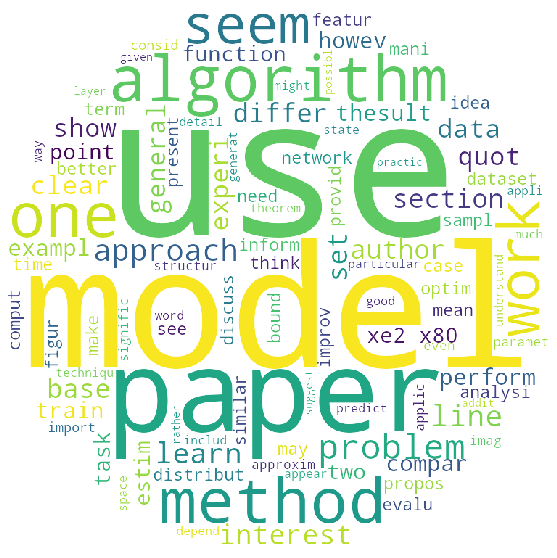

In [0]:


wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)",
                      mode="RGBA",
                      width=800,
                      height=400,
                      max_words = 100,
                      mask=mask
                     ).generate(completestring)
plt.figure( figsize =(20,10))
plt.imshow(wordcloud)
plt.axis('off')

https://www.kaggle.com/veereshelango/nips-analysis
NIPS Descriptive

In [0]:
authors_new = nips_authors.rename(columns = {'id':'author_id'})
paper_authors_new = pd.merge(nips_paper_authors, authors_new, on='author_id', how='left')
nips_authors = nips_authors.rename(columns = {"name":"Author Name"}) 

<Figure size 36000x24000 with 0 Axes>

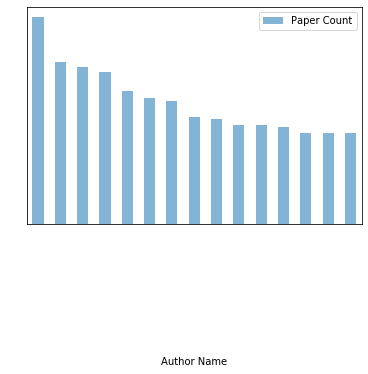

In [0]:
author_paper_count = nips_paper_authors[["author_id","paper_id"]].groupby("author_id").count().sort_values(by="paper_id",ascending=False).reset_index()
author_paper_count = author_paper_count.rename(columns = {'paper_id':'Paper Count'})
authors_new = nips_authors.rename(columns = {'id':'author_id'})
author_paper_count = pd.merge(author_paper_count, authors_new, on="author_id",how="left")
top15_authorsbycount = author_paper_count.iloc[:,1:].head(15)
plt.figure( figsize =(30,20), dpi = 1200)
top15_authorsbycount.plot(x="Author Name",y ="Paper Count", kind='bar', alpha=0.55)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.savefig("nips_author.png", dpi = 500, transparent=True)

In [0]:
plt.title("Highest number of papers published authors")

<Figure size 1080x432 with 0 Axes>

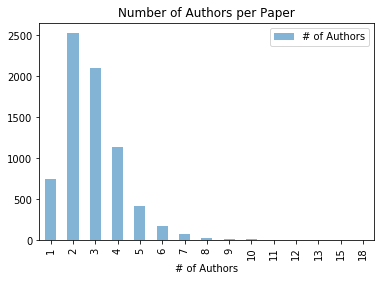

In [0]:
grpby_papers = nips_paper_authors.iloc[:,1:].groupby("paper_id").size().reset_index()
grpby_papers = grpby_papers.rename(columns = {0:'# of Authors'})
num_authors_perpaper = grpby_papers.groupby("# of Authors").size()
plt.figure( figsize =(15,6))
num_authors_perpaper.to_frame().rename(columns = {0:'# of Authors'}).plot(kind='bar', alpha=0.55)
plt.title("Number of Authors per Paper")
plt.savefig("nips_author_pp.png", dpi = 500)

In [0]:
x = nips_paper_authors.groupby("paper_id")["author_id"]
x2 = nips_paper_authors.groupby("author_id")["paper_id"]
authors_dict = {}
for author_id in x2.groups:
    co_authors = []
    #print(author_id)
    #print(x2.get_group(author_id).values)
    for paper_id in x2.get_group(author_id).values:
        z = list(x.get_group(paper_id).values)
        z.remove(author_id)
        co_authors+=z
    authors_dict[author_id]= len(set(co_authors))
co_author_count = pd.Series(authors_dict).sort_values(ascending=False)
co_author_count = co_author_count.reset_index().rename(columns={0:"# of Co-Authors","index":"author_id"})

In [0]:
author_hist = pd.merge(author_paper_count,co_author_count, on= "author_id",how="left")
author_hist.sort_values(by="# of Co-Authors", ascending=False).head(10)

,author_id,Paper Count,Author Name,# of Co-Authors
1,1472,62,Bernhard Sch?lkopf,116
2,178,60,Yoshua Bengio,102
0,330,79,Michael I. Jordan,88
7,3001,41,Lawrence Carin,81
10,1853,38,Andrew Y. Ng,76
4,1020,51,Zoubin Ghahramani,75
11,1282,37,Klaus-Robert M?ller,73
13,2816,35,Ruslan R. Salakhutdinov,64
3,121,58,Geoffrey E. Hinton,63
21,3161,29,Le Song,58


## TF IDF analysis

In [0]:
df1 = df[df['accepted'] == "True"]
df0 = df[df['accepted'] == "False"]

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
import pandas as pd
import re

In [0]:
cvec = CountVectorizer(min_df=3, max_df=0.5, ngram_range=(1,2))
sf = cvec.fit_transform(df['title'])

In [0]:
cvec = CountVectorizer(min_df=3, max_df=0.5, ngram_range=(1,2))
sf = cvec.fit_transform(full_list_rejected)

In [0]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(sf)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})

In [0]:
#full_list_accepted
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
828,university,0.080399
487,of,0.067543
834,university of,0.049748
280,google,0.044423
632,research,0.043650
609,professor,0.038078
204,deepmind,0.026746
698,scientist,0.024955
681,science,0.022709
618,professor of,0.021899


In [0]:
#full_list_rejected
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
2397,university,0.071659
1471,of,0.063920
2417,university of,0.045649
1813,professor,0.034501
1890,research,0.026693
1995,science,0.024756
469,computer,0.023022
472,computer science,0.020545
1837,professor of,0.020403
839,google,0.019494


# ELMo

ELMo is a deep contextualized word representation that models both (1) complex characteristics of word use (e.g., syntax and semantics), and (2) how these uses vary across linguistic contexts (i.e., to model polysemy). These word vectors are learned functions of the internal states of a deep bidirectional language model (biLM), which is pre-trained on a large text corpus. They can be easily added to existing models and significantly improve the state of the art across a broad range of challenging NLP problems, including question answering, textual entailment and sentiment analysis.



ELMo representations are:


*   Contextual: The representation for each word depends on the entire context in which it is used.
*   Deep: The word representations combine all layers of a deep pre-trained neural network.
*   Character based: ELMo representations are purely character based, allowing the network to use morphological clues to form robust representations for out-of-vocabulary tokens unseen in training.


Reference: https://allennlp.org/elmo

In [0]:
import tensorflow_hub as hub
import tensorflow as tf

An example of how ELMo embeddings looks like:

In [0]:
#let's define our ELMo function:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

# just a random sentence
x = ["Cookie's favorite food starts with the letter C"]

# Extract ELMo features 
embeddings = elmo(x, signature="default", as_dict=True)['elmo']

embeddings.shape

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


TensorShape([Dimension(1), Dimension(8), Dimension(1024)])

*   The first dimension of this tensor represents the number of training 
samples. This is 1 in our case.
*   The second dimension represents the maximum length of the longest string in the input list of strings. Since we have only 1 string in our input list, the size of the 2nd dimension is equal to the length of the string – 8
*   The third dimension is equal to the length of the ELMo vector. Hence, every word in the input sentence has an ELMo vector of size 1024.



In [0]:
xtrain = np.array(train["comments"])
ytrain = np.array(train["accepted"])
xtest = np.array(test["comments"])
ytest = np.array(test["accepted"])

Let’s define our ELMo function:

In [0]:
embed = hub.Module("https://tfhub.dev/google/elmo/2")
def ELMoEmbedding(x):
    return embed(tf.reshape(tf.cast(x, tf.string), [-1]), signature="default", as_dict=True)['default']

We define recall, precision and F1 score to add as our metrics.

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Let’s build our NLP model with ELMo!

We will use the ELMo vectors of the train dataset to build a classification model. Then, we will use the model to make predictions on the test set.

In [0]:
def build_model(): 
    input_comment = Input(shape=(1,), dtype="string", name='input_comment')
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_comment)
    dense = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_comment], outputs=pred)
    model.compile(keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy', f1_m]) 
    return model
model_elmo = build_model()
model_elmo.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_comment (InputLayer)   (None, 1)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 262,657
Trainable params: 262,657
Non-trainable params: 0
_________________________________________________________________


Train the model:

In [0]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model_elmo.fit(xtrain, ytrain,validation_data=(xtest, ytest), epochs=10, batch_size=16)
    model_elmo.save_weights('./model_elmo_weights.h5')
    scores={}
    score_gl_test = model_elmo.evaluate([xtest], ytest, verbose=0)
    print('Test acc:', score_gl_test[1])
    print('Test fscore:', score_gl_test[2])

Train on 10309 samples, validate on 3437 samples
Epoch 1/10



10309/10309 [==============================] - 776s 75ms/step - loss: 1.6854 - acc: 0.7006 - f1_m: 0.4852 - val_loss: 1.0690 - val_acc: 0.3762 - val_f1_m: 0.4435
Epoch 2/10
10309/10309 [==============================] - 620s 60ms/step - loss: 1.3083 - acc: 0.6919 - f1_m: 0.4763 - val_loss: 3.1098 - val_acc: 0.7783 - val_f1_m: 0.4873
Epoch 3/10
10309/10309 [==============================] - 611s 59ms/step - loss: 1.9652 - acc: 0.7154 - f1_m: 0.4735 - val_loss: 2.0200 - val_acc: 0.7786 - val_f1_m: 0.4888
Epoch 4/10
10309/10309 [==============================] - 608s 59ms/step - loss: 1.4954 - acc: 0.6958 - f1_m: 0.4756 - val_loss: 0.9835 - val_acc: 0.7786 - val_f1_m: 0.4888
Epoch 5/10
10309/10309 [==============================] - 610s 59ms/step - loss: 3.1831 - acc: 0.7425 - f1_m: 0.4821 - val_loss: 3.1532 - val_acc: 0.7783 - val_f1_m: 0.4873
Epoch 6/10
10309/10309 [==============================] - 596s 58ms/step - loss: 1.9147 - acc: 0.7147 - f1_m: 0.4860 - val_loss: 3.1011 - val_acc:

Evaluation:

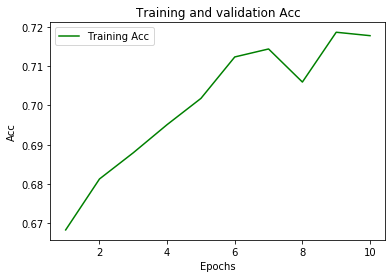

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

# ULMFit

In [0]:
pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

In [0]:
pip install fastai

In [0]:
import fastai
from fastai import *
from fastai.text import * 
from functools import partial
import io

**Language Model:**

This does all the necessary pre-processing behind the scene. We can use the data_lm object to fine-tune a pretrained language model.

In [0]:
#Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

In [0]:
learn = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True, drop_mult=0.7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


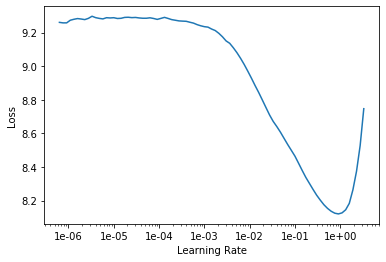

In [0]:
learn.lr_find()
learn.recorder.plot()

Leslie Smith recommends to do a cycle with two steps of equal lengths, one going from a lower learning rate to a higher one than go back to the minimum. The maximum should be the value picked with the Learning Rate Finder, and the lower one can be ten times lower. Then, the length of this cycle should be slightly less than the total number of epochs, and, in the last part of training, we should allow the learning rate to decrease more than the minimum, by several orders of magnitude.

Reference: https://sgugger.github.io/the-1cycle-policy.html

Basically for training recurrent neural networks (RNNs), it really helps to decrease the momentum a little bit. Every time our learning rate is small, our momentum is high because as you are learning small learning rate, but you keep going in the same direction, you may as well go faster (higher momentum). But as you are learning high learning rate, but you keep going in the same direction, you may overshoot the target, so momentum should be slowed. This trick can help you train 10 times faster.

Reference: Fastai lesson 4, Jeremy Howard.

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7)) # training only the head

epoch,train_loss,valid_loss,accuracy,time
0,7.849431,6.545413,0.107709,00:07


It trained last layers and basically left most of the model exactly as it was. But what we really want is to train the whole model. Normally after we fine-tune the last layers, the next thing we do is we go unfreeze (unfreeze the whole model for training) and train the whole thing.


In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7)) # training the complete model


epoch,train_loss,valid_loss,accuracy,time
0,6.850548,6.418310,0.126116,00:09
1,6.748893,6.292697,0.130735,00:09
2,6.641838,6.212232,0.133122,00:09
3,6.526557,6.121772,0.136247,00:09
4,6.396333,6.087207,0.134667,00:09
5,6.260986,6.070477,0.134598,00:09
6,6.124630,6.060961,0.134667,00:09
7,5.990198,6.071137,0.133911,00:09
8,5.882430,6.076581,0.132572,00:09
9,5.799819,6.079064,0.131628,00:09


The accuracy implies how good the language model is at predicting the next word in the sentence.

In [0]:
learn.predict("This paper proposes", 10, temperature = 1.1, min_p = 0.001)

'This paper proposes novel mani exist approach deep learn general idea use infer'

In [0]:
learn.save('ft_lm') # saving the complete language model

Now we will save the encoder that understand the meaning of the sentence.

In [0]:
learn.save_encoder('ft_enc') # saving only the encoder part of the language model

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val,
                                      vocab=data_lm.vocab, bs=32, label_cols='accepted', text_cols='comments')

In [0]:
# Classifier learner
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='macro',beta=1)])
#learn.load_encoder('ft_enc')

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


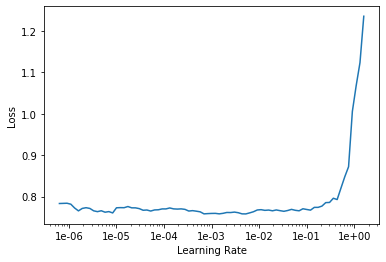

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.782047,0.766341,0.256055,0.203857,00:08


In [0]:
learn.save('first')
#learn.load('first')

We won't unfreeze the whole model but only the last two layers.

In [0]:
## Gradually unfreezing 
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.749259,0.697069,0.259516,0.209050,00:09


If you pass slice(start,end) then the first group's learning rate is start, the last is end, and the remaining are evenly spaced.

The bottom of the slice and the top of the slice is the difference between how quickly the lowest layer of the model learns versus the highest layer of the model learns. As you go from layer to layer, we decrease the learning rate. The lowest levels are given smaller learning rates so as not to disturb the weights much.

In [0]:
learn.save('2nd')
# learn.load('2nd')

Now we unfreeze our three LSTM layers.

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.713324,0.715449,0.256055,0.203857,00:12


In [0]:
learn.save('3rd')

In [0]:
learn.save('clas')

Again, we unfreeze the complete model and train it: 

In [0]:
## training the complete model
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.695673,0.701711,0.287197,0.249218,00:15
1,0.690448,0.678544,0.688581,0.532463,00:15


Let's try!

In [0]:
learn.predict("I recommend this paper to be accepted.")

(Category 1, tensor(1), tensor([0.1892, 0.8108]))

In [0]:
learn.predict("I do not recommend this paper.")

(Category 0, tensor(0), tensor([0.5752, 0.4248]))

Add test data for the prediction task:


In [0]:
learn.data.add_test(df_val) 

In [0]:
predictions, *_ = learn.get_preds(DatasetType.Test) # making predictions 
labels = np.argmax(predictions, 1)

In [0]:
accuracy = accuracy_score(df_val['accepted'], labels)
f_score = f1_score(df_val['accepted'], labels)
print(accuracy)
print(f_score)

# Benchmark - Lasso

In [0]:
train, test = train_test_split(df, test_size=0.25, random_state=12)

In [0]:
xtrain = np.array(train["abstract"])
ytrain = np.array(train["accepted"])
xtest = np.array(test["abstract"])
ytest = np.array(test["accepted"])

In [0]:
lasso = Lasso()

In [0]:
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

In [0]:
lasso_regressor = GridSearchCV(lasso, parameters, cv=5)

In [0]:
# Step - 4: Vectorize the words by using TF-IDF Vectorizer - This is done to find how important a word in document is in comaprison to the corpus
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(xtrain)

xtrain = Tfidf_vect.transform(xtrain)
xtest = Tfidf_vect.transform(xtest)


In [0]:
lasso_regressor.fit(xtrain, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.07782147807617, tolerance: 0.18496721231963156
  max_iter, tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.48959494045067, tolerance: 0.18409242148659957
  max_iter, tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4449453000700032, tolerance: 0.1847743421850372
  max_iter, tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did no

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
lasso_regressor.best_params_

{'alpha': 0.0001}

In [0]:
lasso_regressor.best_score_

0.27800555850189185

In [0]:
prediction = lasso_regressor.predict(xtest)

In [0]:
prediction2 = lasso_regressor.predict(xtrain)

In [0]:
predictions = np.where(prediction < 0.5, 0, 1)

In [0]:
predictions2 = np.where(prediction2 < 0.5, 0, 1)

In [0]:
print("Lasso Test Accuracy Score -> ",accuracy_score(predictions, ytest)*100)

Lasso Test Accuracy Score ->  76.78207739307535


In [0]:
print("Lasso Train Accuracy Score -> ",accuracy_score(predictions2, ytrain)*100)

Lasso Train Accuracy Score ->  79.93985837617615


In [0]:
f_score_test = f1_score(ytest, predictions)
f_score_test

0.58

In [0]:
f_score_train = f1_score(ytrain, predictions2)
f_score_train

0.6491347132677299

# SVM (auxuliary data)

## Support Vector Machine -only affiliation

In [0]:
df['affiliation']= df['affiliation'].astype(str)

In [0]:
# Step - 2: Split the model into Train and Test Data set
df_trn, df_val = train_test_split(df, test_size=0.25, random_state=12)

Train_X = df_trn['comments']
Train_Y = df_trn['accepted']

Test_X = df_val['comments']
Test_Y = df_val['accepted']

In [0]:
# Step - 3: Label encode the target variable  - This is done to transform Categorical data of string type in the data set into numerical values
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)


In [0]:
# Step - 4: Vectorize the words by using TF-IDF Vectorizer - This is done to find how important a word in document is in comaprison to the corpus
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Train_X)

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)


In [0]:
# Step - 5: Now we can run different algorithms to classify out data check for accuracy

# Classifier - Algorithm - Naive Bayes
# fit the training dataset on the classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)



# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)


# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_SVM_aff = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM_aff, Test_Y)*100)

Naive Bayes Accuracy Score ->  69.28571428571428
SVM Test Accuracy Score ->  72.85714285714285


In [0]:
# predict the labels on validation dataset
predictions_SVM2 = SVM.predict(Train_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Train Accuracy Score -> ",accuracy_score(predictions_SVM2, Train_Y)*100)

SVM Train Accuracy Score ->  98.80952380952381


In [0]:
from sklearn.metrics import f1_score

print("train F1 Score", f1_score(Train_Y, predictions_SVM2)) #train
print("test F1 Score", f1_score(Test_Y, predictions_SVM_aff)) #test


train F1 Score 0.9910233393177738
test F1 Score 0.8256880733944955


## Support Vector Machine -affiliation + review

In [0]:
df_trn, df_val = train_test_split(df, test_size=0.25, random_state=12)

In [0]:
# Step - 2: Split the model into Train and Test Data set
Train_X = df_trn[['affiliation', 'comments']]
Train_Y = df_trn['accepted']

Test_X = df_val[['affiliation', 'comments']]
Test_Y = df_val['accepted']

In [0]:
# Step - 3: Label encode the target variable  - This is done to transform Categorical data of string type in the data set into numerical values
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)


In [0]:
vectorizer = TfidfVectorizer(min_df=3)

Train_X_Tfidf = vectorizer.fit_transform(list(Train_X['affiliation']), list(Train_X['comments']))

In [0]:
Test_X_Tfidf = vectorizer.transform(list(Test_X['affiliation']), list(Test_X['comments']))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1897: FutureWarning: 'copy' param is unused and has been deprecated since version 0.22. Backward compatibility for 'copy' will be removed in 0.24.
  warnings.warn(msg, FutureWarning)


In [0]:
# Step - 5: Now we can run different algorithms to classify out data check for accuracy

# Classifier - Algorithm - Naive Bayes
# fit the training dataset on the classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)



# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)


# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_SVM_aff = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM_aff, Test_Y)*100)

Naive Bayes Accuracy Score ->  65.71428571428571
SVM Test Accuracy Score ->  65.71428571428571


In [0]:
# predict the labels on validation dataset
predictions_SVM2 = SVM.predict(Train_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Train Accuracy Score -> ",accuracy_score(predictions_SVM2, Train_Y)*100)

SVM Train Accuracy Score ->  70.95238095238095


In [0]:
from sklearn.metrics import f1_score

print("train F1 Score", f1_score(Train_Y, predictions_SVM2)) #train
print("test F1 Score", f1_score(Test_Y, predictions_SVM_aff)) #test


train F1 Score 0.8151515151515152
test F1 Score 0.7894736842105263
